# News Category Prediction Problem

## Importing Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
train_data = pd.read_excel('Data_Train.xlsx')
test_data = pd.read_excel('Data_Test.xlsx')


In [0]:
train_data.head(10)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3
5,BEIJING: Chinese tech giant Huawei has announc...,1
6,Mumbai: India Inc's external commercial borrow...,3
7,"On Wednesday, Federal Reserve Chairman Jerome ...",3
8,What more can you give to the audience? I have...,2
9,"com, Arbaaz Khan spoke about getting back to D...",2


In [0]:
print("Number of data points in train data", train_data.shape)
print('-'*50)
print("The attributes of data :", train_data.columns.values)


Number of data points in train data (7628, 2)
--------------------------------------------------
The attributes of data : ['STORY' 'SECTION']


# Text Preprocessing

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
len(stopwords)

176

In [0]:
from tqdm import tqdm
preprocessed_train_data = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_train_data.append(sent.lower().strip())


100%|██████████| 7628/7628 [00:02<00:00, 3408.83it/s]


In [0]:
train_data['preprocessed_STORY'] = preprocessed_train_data
train_data.drop(['STORY'], axis=1, inplace=True)

In [0]:
from tqdm import tqdm
preprocessed_test_data = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_test_data.append(sent.lower().strip())

100%|██████████| 2748/2748 [00:00<00:00, 3397.99it/s]


In [0]:
test_data['preprocessed_STORY'] = preprocessed_test_data
test_data.drop(['STORY'], axis=1, inplace=True)

In [0]:
train_data['preprocessed_STORY']

train_data.shape

train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

## Splitting Dataset

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [0]:
train_data[train_data.isnull().any(axis=1)]

,SECTION,preprocessed_STORY


In [0]:
y=train_data['SECTION']
y.shape

(7628,)

In [0]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true'
X_train, test_df, y_train, y_test = train_test_split(train_data, y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train'
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

In [0]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 4881
Number of data points in test data: 1526
Number of data points in cross validation data: 1221


In [0]:
train_class_distribution = train_df['SECTION'].value_counts()
type(train_class_distribution)

pandas.core.series.Series

## Distribution of y_i's in Train, Test and Cross Validation datasets

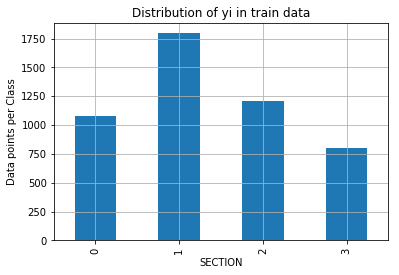

Number of data points in class 2 : 1795 ( 36.775 %)
Number of data points in class 3 : 1206 ( 24.708 %)
Number of data points in class 1 : 1081 ( 22.147 %)
Number of data points in class 4 : 799 ( 16.37 %)
--------------------------------------------------------------------------------


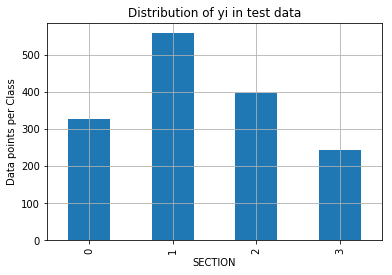

Number of data points in class 2 : 558 ( 36.566 %)
Number of data points in class 3 : 398 ( 26.081 %)
Number of data points in class 1 : 326 ( 21.363 %)
Number of data points in class 4 : 244 ( 15.99 %)
--------------------------------------------------------------------------------


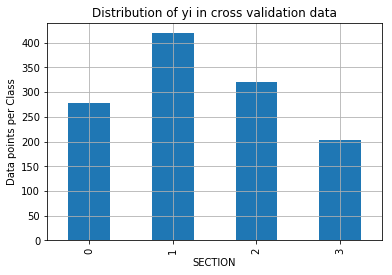

Number of data points in class 2 : 419 ( 34.316 %)
Number of data points in class 3 : 320 ( 26.208 %)
Number of data points in class 1 : 279 ( 22.85 %)
Number of data points in class 4 : 203 ( 16.626 %)


In [0]:
train_class_distribution = train_df['SECTION'].value_counts().sort_index()
test_class_distribution = test_df['SECTION'].value_counts().sort_index()
cv_class_distribution = cv_df['SECTION'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## Univariate Analysis on Text Feature

In [0]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [0]:
import collections
from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['preprocessed_STORY'].split():
            dictionary[word] +=1
    return dictionary


In [0]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],4))
    for i in range(0,3):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['preprocessed_STORY'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+40)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['preprocessed_STORY'].split()))
            row_index += 1
    return text_feature_responseCoding


In [0]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=2)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['preprocessed_STORY'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 15392


In [0]:
dict_list = []
# dict_list =[] contains 4 dictoinaries each corresponds to a class
for i in range(0,3):
    cls_text = train_df[train_df['SECTION']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,3):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+40))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [0]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [0]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [0]:
from sklearn.preprocessing import Normalizer
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['preprocessed_STORY'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['preprocessed_STORY'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [0]:
# we use the same vectorizer that was trained on train data
data_test_text__onehotCoding = text_vectorizer.transform(test_data['preprocessed_STORY'])
# don't forget to normalize every feature
data_test__onehotCoding = normalize(data_test_text__onehotCoding, axis=0)

In [0]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [0]:
print(Counter(sorted_text_occur))

Counter({2: 3627, 3: 2106, 4: 1391, 5: 1019, 6: 773, 7: 564, 8: 507, 9: 411, 10: 335, 11: 292, 12: 241, 14: 211, 13: 205, 15: 159, 16: 152, 17: 141, 18: 140, 21: 126, 19: 126, 20: 124, 22: 97, 24: 94, 25: 91, 23: 86, 27: 71, 26: 70, 30: 67, 29: 59, 35: 56, 31: 53, 34: 51, 36: 50, 28: 50, 39: 49, 33: 42, 38: 41, 32: 40, 41: 39, 37: 37, 56: 36, 45: 34, 40: 31, 49: 30, 46: 30, 52: 29, 51: 29, 48: 29, 47: 29, 43: 29, 42: 28, 54: 26, 53: 23, 44: 23, 73: 19, 66: 19, 62: 19, 57: 19, 55: 19, 50: 19, 63: 18, 83: 17, 60: 17, 74: 16, 70: 16, 64: 16, 59: 16, 58: 16, 69: 15, 61: 15, 85: 14, 68: 14, 78: 13, 71: 13, 95: 12, 86: 12, 80: 12, 105: 11, 79: 11, 75: 11, 72: 11, 120: 10, 90: 10, 89: 10, 87: 10, 77: 10, 76: 10, 67: 10, 65: 10, 101: 9, 94: 9, 92: 9, 81: 9, 153: 8, 127: 8, 126: 8, 121: 8, 104: 8, 103: 8, 100: 8, 88: 8, 146: 7, 143: 7, 134: 7, 125: 7, 106: 7, 98: 7, 176: 6, 160: 6, 140: 6, 129: 6, 123: 6, 122: 6, 119: 6, 116: 6, 115: 6, 114: 6, 111: 6, 107: 6, 97: 6, 91: 6, 84: 6, 233: 5, 204: 

For values of alpha =  1e-05 The log loss is: 0.10998031510152115
For values of alpha =  0.0001 The log loss is: 0.10842857267919888
For values of alpha =  0.001 The log loss is: 0.11904716012533001
For values of alpha =  0.01 The log loss is: 0.15813804240734972
For values of alpha =  0.1 The log loss is: 0.18515670641661394
For values of alpha =  1 The log loss is: 0.19628647824145845


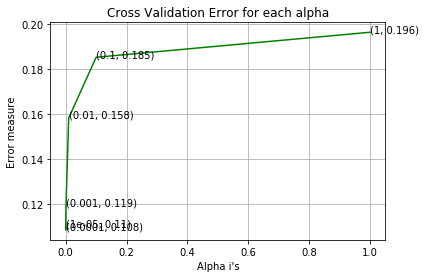

For values of best alpha =  0.0001 The train log loss is: 0.05898349780347368
For values of best alpha =  0.0001 The cross validation log loss is: 0.10842857267919888
For values of best alpha =  0.0001 The test log loss is: 0.14240273425385155


In [0]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Text feature stable across all the data sets (Test, Train, Cross validation)

In [0]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['preprocessed_STORY'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

98.236 % of word of test data appeared in train data
98.596 % of word of Cross Validation appeared in train data


# Machine Learning Models

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [0]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Prepare final  dataset

In [0]:
train_x_onehotCoding = ((train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['SECTION']))

test_x_onehotCoding = ((test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['SECTION']))

cv_x_onehotCoding = ((cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['SECTION']))

In [0]:
train_x_responseCoding = ((train_text_feature_responseCoding))
test_x_responseCoding = ((test_text_feature_responseCoding))
cv_x_responseCoding = ((cv_text_feature_responseCoding))


In [0]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [0]:
train_data["SECTION"].value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [0]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (4881, 15392)
(number of data points * number of features) in test data =  (1526, 15392)
(number of data points * number of features) in cross validation data = (1221, 15392)


In [0]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)


 Response encoding features :
(number of data points * number of features) in train data =  (4881, 4)
(number of data points * number of features) in test data =  (1526, 4)
(number of data points * number of features) in cross validation data = (1221, 4)


## Base Line Model

## Naive Bayes

## Hyper parameter tuning

for alpha = 1e-05
Log Loss : 0.2430945434636596
for alpha = 0.0001
Log Loss : 0.21741985308371675
for alpha = 0.001
Log Loss : 0.18989212189119203
for alpha = 0.1
Log Loss : 0.15544954063402963
for alpha = 1
Log Loss : 0.12859680634879336
for alpha = 10
Log Loss : 0.12926583019417176
for alpha = 100
Log Loss : 0.15475196913515124
for alpha = 1000
Log Loss : 0.1545688585348822


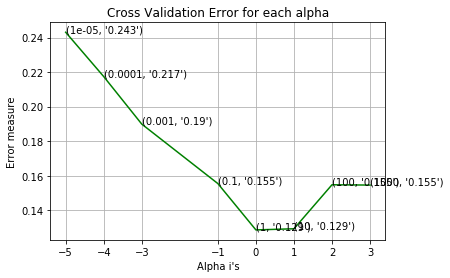

For values of best alpha =  1 The train log loss is: 0.06952851189404424
For values of best alpha =  1 The cross validation log loss is: 0.12859680634879336
For values of best alpha =  1 The test log loss is: 0.14358221534382112


In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Testing the model with best hyper paramters

Log Loss : 0.12859680634879336
Number of missclassified point : 0.03849303849303849
-------------------- Confusion matrix --------------------


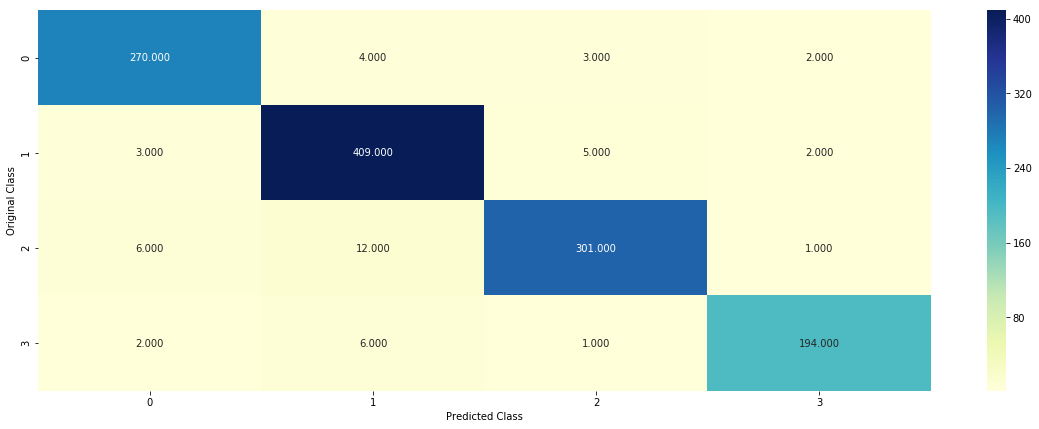

-------------------- Precision matrix (Columm Sum=1) --------------------


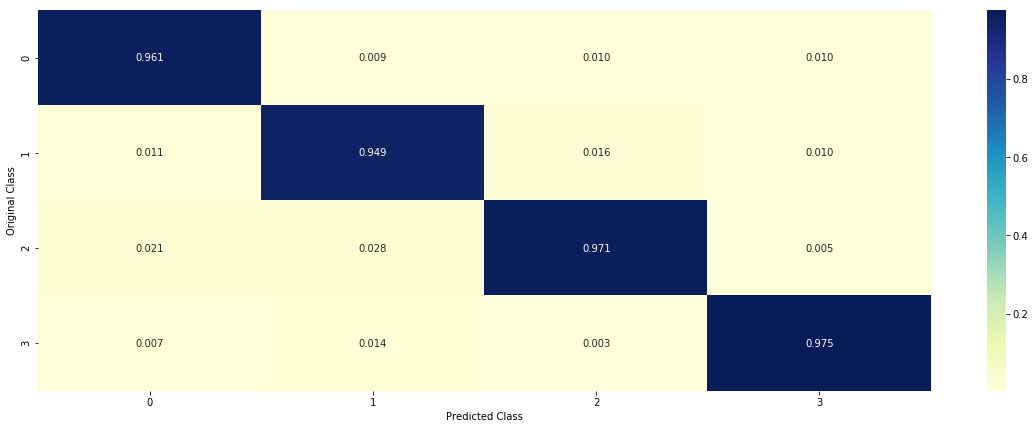

-------------------- Recall matrix (Row sum=1) --------------------


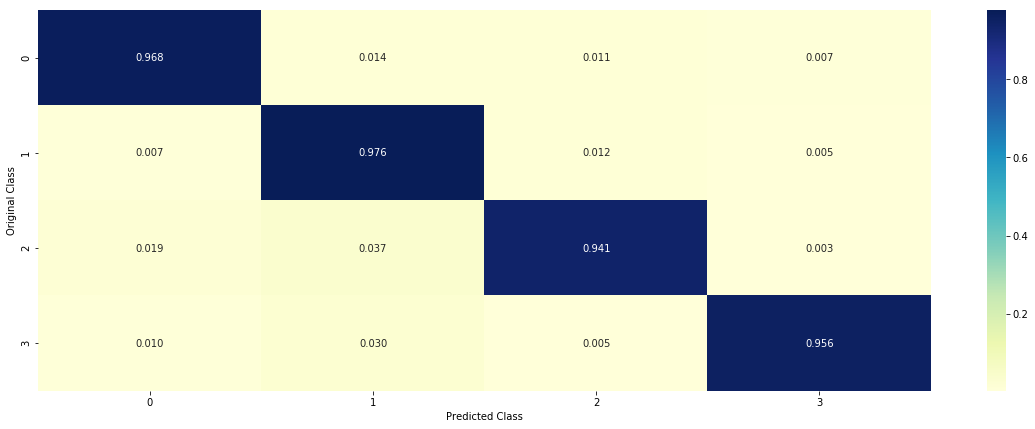

Predicted Class : 1
Predicted Class Probabilities: [[0.0045 0.988  0.0044 0.0031]]
Actual Class : 1


In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

"""### Correctly classified point"""

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])


## K Nearest Neighbour Classification

## Hyper parameter tuning

for alpha = 5
Log Loss : 0.3273641138853152
for alpha = 11
Log Loss : 0.3196425587714299
for alpha = 15
Log Loss : 0.31568519771916376
for alpha = 21
Log Loss : 0.3207420255033914
for alpha = 31
Log Loss : 0.32670395980784794
for alpha = 41
Log Loss : 0.3270915171782146
for alpha = 51
Log Loss : 0.32729758409461357
for alpha = 99
Log Loss : 0.3317787771808088


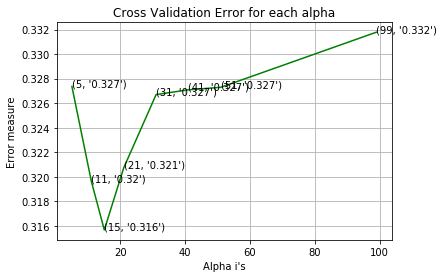

For values of best alpha =  15 The train log loss is: 0.23054857753485614
For values of best alpha =  15 The cross validation log loss is: 0.31568519771916376
For values of best alpha =  15 The test log loss is: 0.2988124785696775


In [0]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Testing the model with best hyper paramters

Log loss : 0.31568519771916376
Number of mis-classified points : 0.10073710073710074
-------------------- Confusion matrix --------------------


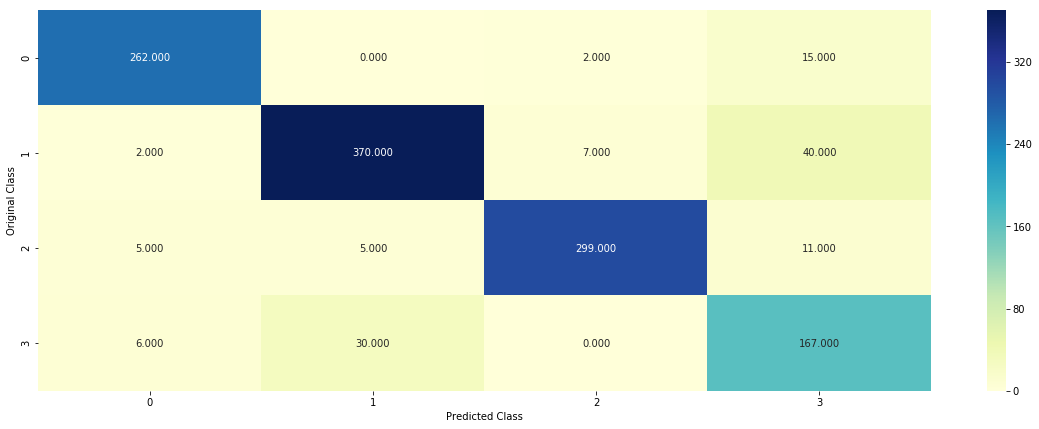

-------------------- Precision matrix (Columm Sum=1) --------------------


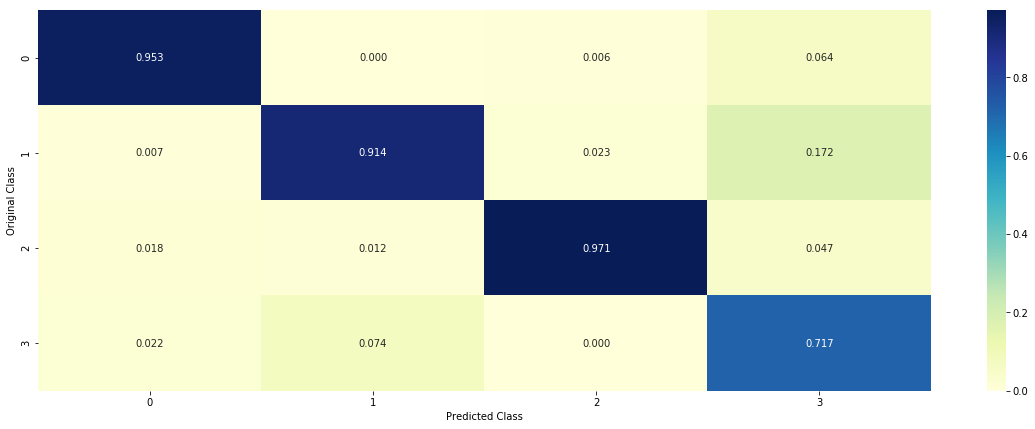

-------------------- Recall matrix (Row sum=1) --------------------


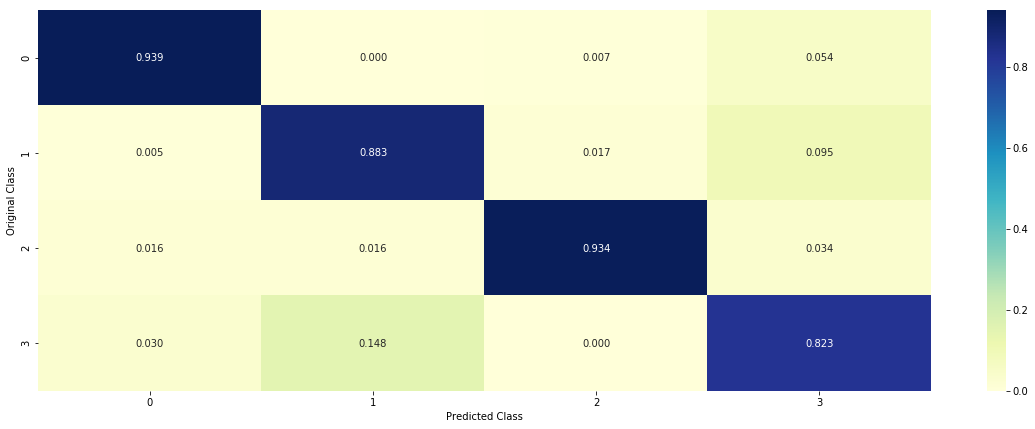

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
The  15  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 15})


In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 15})


## Logistic Regression(With Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.1617386375419943
for alpha = 1e-05
Log Loss : 0.1140879244035987
for alpha = 0.0001
Log Loss : 0.10832952621088365
for alpha = 0.001
Log Loss : 0.12253600126225576
for alpha = 0.01
Log Loss : 0.1521994333371923
for alpha = 0.1
Log Loss : 0.19225963842748098
for alpha = 1
Log Loss : 0.21896308007636636
for alpha = 10
Log Loss : 0.22399309491619085
for alpha = 100
Log Loss : 0.22483056366654483


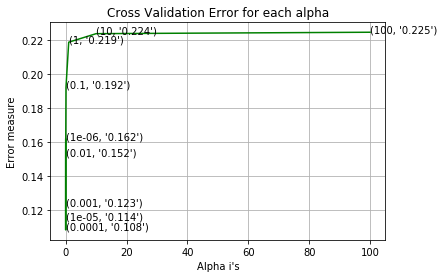

For values of best alpha =  0.0001 The train log loss is: 0.06030788963977693
For values of best alpha =  0.0001 The cross validation log loss is: 0.10832952621088365
For values of best alpha =  0.0001 The test log loss is: 0.14352062627697088


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyper paramters

Log loss : 0.10832952621088365
Number of mis-classified points : 0.031122031122031123
-------------------- Confusion matrix --------------------


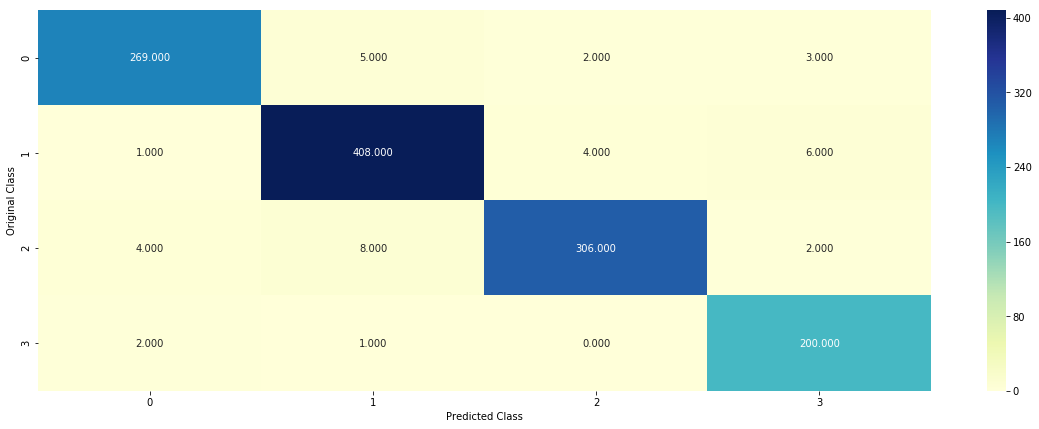

-------------------- Precision matrix (Columm Sum=1) --------------------


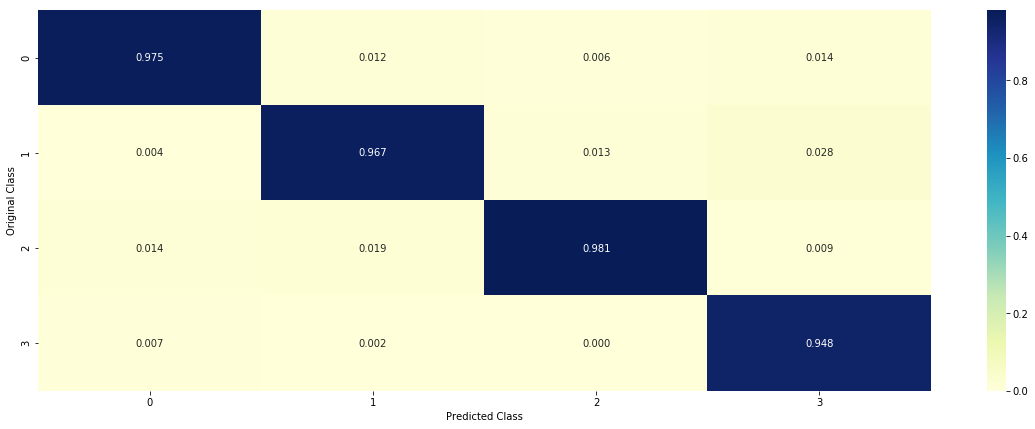

-------------------- Recall matrix (Row sum=1) --------------------


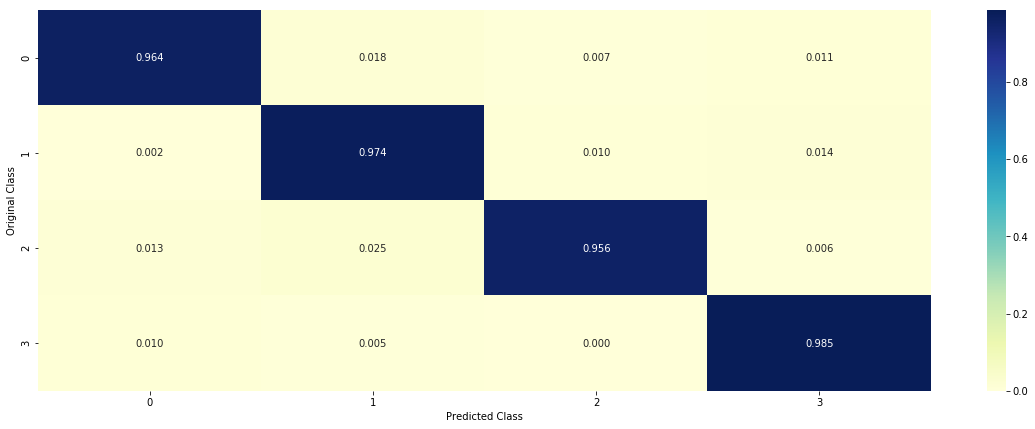

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])


Predicted Class : 1
Predicted Class Probabilities: [[4.100e-03 9.926e-01 3.100e-03 3.000e-04]]
Actual Class : 1


## Logistic Regression(Without Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.1631128424792667
for alpha = 1e-05
Log Loss : 0.10998031510152115
for alpha = 0.0001
Log Loss : 0.10842857267919888
for alpha = 0.001
Log Loss : 0.11904716012533001
for alpha = 0.01
Log Loss : 0.15813804240734972
for alpha = 0.1
Log Loss : 0.18515670641661394
for alpha = 1
Log Loss : 0.19628647824145845


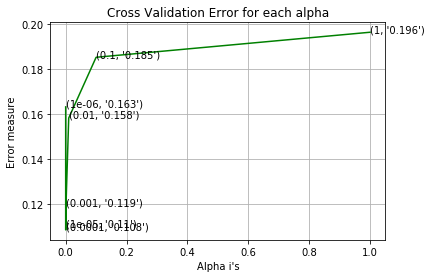

For values of best alpha =  0.0001 The train log loss is: 0.05898349780347368
For values of best alpha =  0.0001 The cross validation log loss is: 0.10842857267919888
For values of best alpha =  0.0001 The test log loss is: 0.14240273425385155


In [0]:

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log loss : 0.10842857267919888
Number of mis-classified points : 0.030303030303030304
-------------------- Confusion matrix --------------------


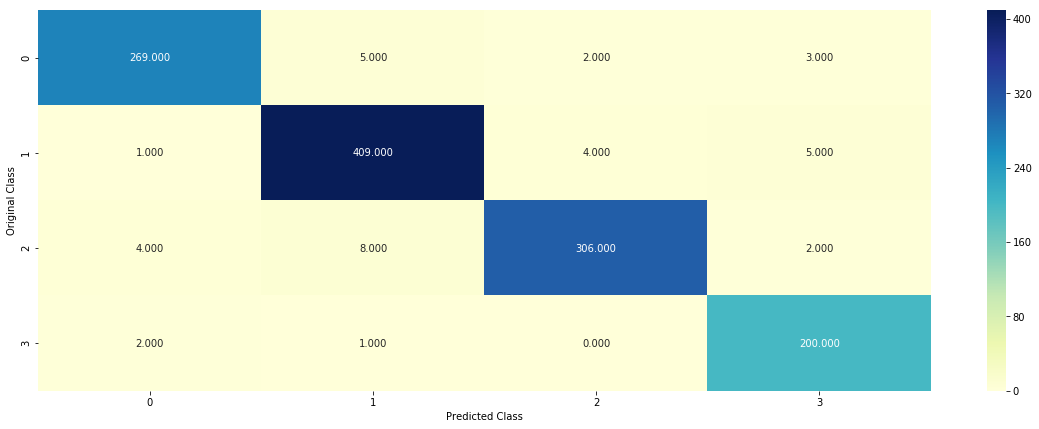

-------------------- Precision matrix (Columm Sum=1) --------------------


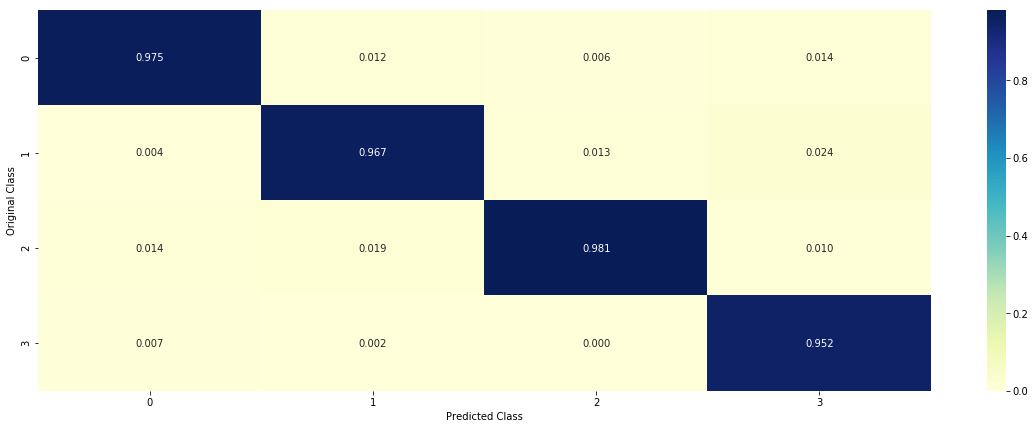

-------------------- Recall matrix (Row sum=1) --------------------


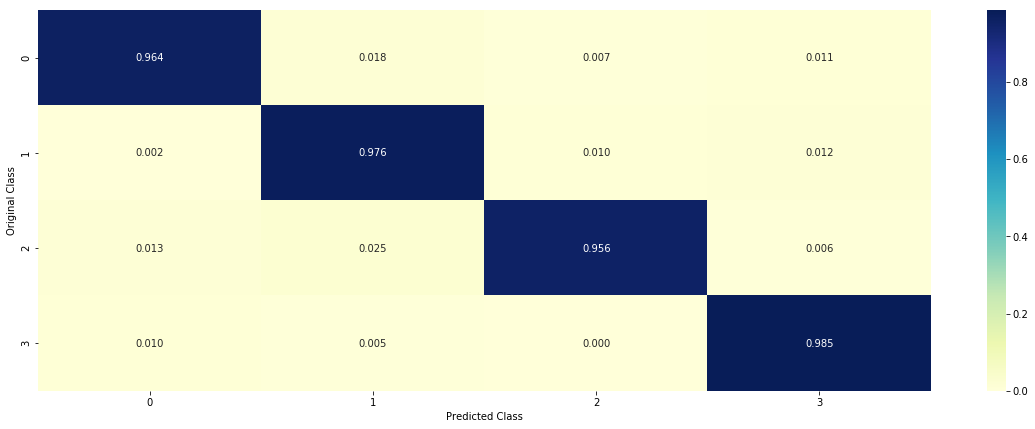

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[4.100e-03 9.925e-01 3.100e-03 3.000e-04]]
Actual Class : 1


## Linear Support Vector Machines

### Hyper paramter tuning

In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for C = 1e-05
Log Loss : 0.13819126655637934
for C = 0.0001
Log Loss : 0.12857094381203168
for C = 0.001
Log Loss : 0.152711321712342
for C = 0.01
Log Loss : 0.19913629232704697
for C = 0.1
Log Loss : 0.22429856141677665
for C = 1


### Testing model with best hyper parameters

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

## Random Forest Classifier(With One hot Encoding)

### Hyper paramter tuning

In [0]:
alpha = [100,200,500,1000,2000]
max_depth = [2,3,5,7,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 100 and max depth =  2
Log Loss : 0.31810705493882047
for n_estimators = 100 and max depth =  3
Log Loss : 0.28408181834316526
for n_estimators = 100 and max depth =  5
Log Loss : 0.25445820086217175
for n_estimators = 100 and max depth =  7
Log Loss : 0.23442827013112288
for n_estimators = 100 and max depth =  10
Log Loss : 0.21769945532774426
for n_estimators = 200 and max depth =  2
Log Loss : 0.27294026428260726
for n_estimators = 200 and max depth =  3
Log Loss : 0.26010951084288514
for n_estimators = 200 and max depth =  5
Log Loss : 0.2414611708432414
for n_estimators = 200 and max depth =  7
Log Loss : 0.2208993724123441
for n_estimators = 200 and max depth =  10
Log Loss : 0.2076296224356148
for n_estimators = 500 and max depth =  2
Log Loss : 0.2418102578371336
for n_estimators = 500 and max depth =  3
Log Loss : 0.2341767513312301
for n_estimators = 500 and max depth =  5
Log Loss : 0.22226814885524088
for n_estimators = 500 and max depth =  7
Log Loss : 0

### Testing model with best hyper parameters (One Hot Encoding)

Log loss : 0.1991927144309127
Number of mis-classified points : 0.06060606060606061
-------------------- Confusion matrix --------------------


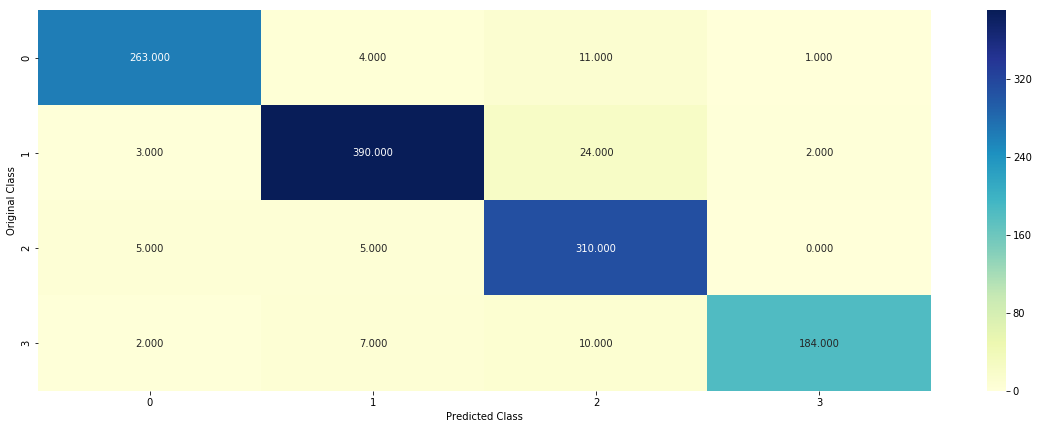

-------------------- Precision matrix (Columm Sum=1) --------------------


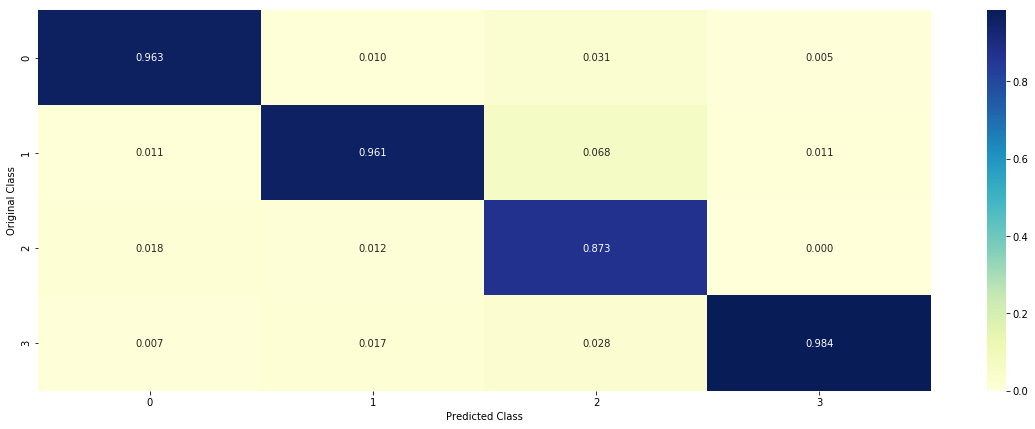

-------------------- Recall matrix (Row sum=1) --------------------


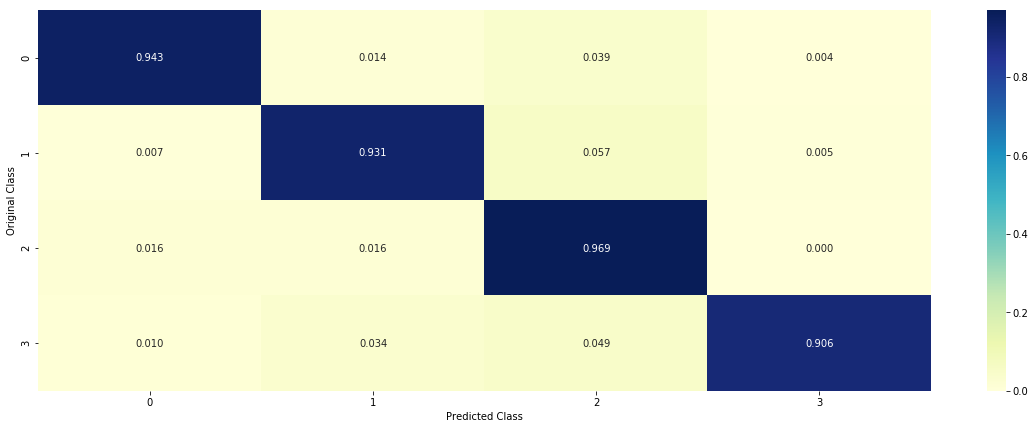

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)


In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

## Random Forest Classifier(With Response Coding)

In [0]:
alpha = [10,50,100,200,500,1000,2000]
max_depth = [2,3,5,7,10,15,20]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
        
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_depth=max_depth[int(best_alpha%7)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 10 and max depth =  2
Log Loss : 0.3271820135818559
for n_estimators = 10 and max depth =  3
Log Loss : 0.3338515913194429
for n_estimators = 10 and max depth =  5
Log Loss : 0.3339388386972617
for n_estimators = 10 and max depth =  7
Log Loss : 0.32498450781930427
for n_estimators = 10 and max depth =  10
Log Loss : 0.3170296889798442
for n_estimators = 10 and max depth =  15
Log Loss : 0.3247159320552882
for n_estimators = 10 and max depth =  20
Log Loss : 0.328794112818755
for n_estimators = 50 and max depth =  2
Log Loss : 0.3339652037069612
for n_estimators = 50 and max depth =  3
Log Loss : 0.3362003525700234
for n_estimators = 50 and max depth =  5
Log Loss : 0.3315398386395064
for n_estimators = 50 and max depth =  7
Log Loss : 0.31973719824927543
for n_estimators = 50 and max depth =  10
Log Loss : 0.31616187822769587
for n_estimators = 50 and max depth =  15
Log Loss : 0.31679995175216225
for n_estimators = 50 and max depth =  20
Log Loss : 0.32228736405026

In [0]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%7)], n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_depth=max_depth[int(best_alpha%7)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

## Stack the models

### testing with hyper parameter tuning

In [0]:
clf1 = SGDClassifier(alpha=0.0001 , penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)


clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

clf4 = RandomForestClassifier(max_depth=10, n_estimators=2000, criterion='gini', max_features='auto',random_state=42)
clf4.fit(train_x_onehotCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf4.fit(train_x_onehotCoding, train_y)

clf5 = KNeighborsClassifier(n_neighbors=41)
clf5.fit(train_x_responseCoding, train_y)
sig_clf5 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf5.fit(train_x_onehotCoding, train_y)



print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("Random forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_onehotCoding))))

print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_onehotCoding))))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10,20,50] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error


Logistic Regression :  Log Loss: 0.22
Support vector machines : Log Loss: 0.22
Naive Bayes : Log Loss: 0.22
Random forest : Log Loss: 0.22
K Nearest Neighbour : Log Loss: 0.22
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.233
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.695
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.293
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.208
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.198
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.197
Stacking Classifer : for the value of alpha: 20.000000 Log Loss: 0.197
Stacking Classifer : for the value of alpha: 50.000000 Log Loss: 0.197


### testing the model with the best hyper parameters

In [0]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [0]:
predictions = sclf.predict(data_test__onehotCoding)
print(predictions)

In [0]:
new_series = pd.Series(predictions)
new_series.value_counts()

In [0]:
train_data.head(10)

,SECTION,preprocessed_STORY
0,3,but painful huge reversal fee income unheard a...
1,0,how formidable opposition alliance among congr...
2,3,most asian currencies trading lower today sout...
3,1,if want answer question click answer after cli...
4,3,in global markets gold prices edged today disa...
5,1,beijing chinese tech giant huawei announced pl...
6,3,mumbai india inc external commercial borrowing...
7,3,on wednesday federal reserve chairman jerome p...
8,2,what give audience i already done yeh hai aash...
9,2,com arbaaz khan spoke getting back dabangg sal...


In [0]:
predictions = pd.DataFrame(new_series, columns=['SECTION'])
predictions.to_excel("News_category_submission.xlsx", index=False)

In [0]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3),('rf', sig_clf4),('knn', sig_clf5)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))